#geopandas 

## Goals 

The goal of this is to compare Above ground biomass(abg) and the RH Values from LVIS.Then for they are grouped by subplot 625 to get the data at the subplot 625 level. The ABG data come tree measurement. Then RH come from the LVIS L1 product. The is join in GIS use a spatail Join. Then they are join with the plot level data. After they are joined they are grouped Plot. The ABG is Summed if there are multiple trees. Each of the RH values are average by plot. This provieds a sum of agb and avg RH value per plot. 

#https://lvis.gsfc.nasa.gov/workshop/LVIS_QGIS_Tutorial_Gabon.pdf

In [18]:
import matplotlib.pyplot 
import numpy as np
import pylab
import pandas as pd
import h5py
import geopandas as gpd
from shapely.geometry import *
from geopandas.geoseries import *

Bring all the data data in 

In [19]:
# Geopandas 

In [20]:
PLOT_RH = pd.read_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\PLOT025_AGB_RH.csv')

In [21]:
PLOT_RH.columns

Index(['Subplot_25', 'AGB', 'RH10', 'RH15', 'RH20', 'RH25', 'RH30', 'RH35',
       'RH40', 'RH45', 'RH50', 'RH55', 'RH60', 'RH65', 'RH80', 'RH70', 'RH75',
       'RH85', 'RH90', 'RH95', 'RH96', 'RH97', 'RH99', 'RH98', 'RH100'],
      dtype='object')

In [22]:
PLOT_RH.head(3)

,Subplot_25,AGB,RH10,RH15,RH20,RH25,RH30,RH35,RH40,RH45,...,RH70,RH75,RH85,RH90,RH95,RH96,RH97,RH99,RH98,RH100
0,NASA01_1.1,1938.80,-1.237407,-0.622593,-0.113519,0.450000,1.029074,1.721296,2.522407,3.389444,...,6.920185,7.440000,8.484815,9.157037,10.087778,10.338333,10.692778,11.791111,11.127407,13.288519
1,NASA01_1.2,3478.87,-1.020189,-0.333396,0.253962,0.834717,1.416038,2.063396,2.747170,3.491132,...,6.504528,6.974340,7.947170,8.580755,9.520943,9.817170,10.183208,11.441887,10.676981,13.073019
2,NASA01_2.1,11474.29,-1.763214,-1.365714,-1.046190,-0.770119,-0.486310,-0.267262,-0.034524,0.245000,...,1.867738,2.248929,3.171190,4.001310,5.304405,5.885238,6.466310,8.058810,7.107024,9.692500


##### Finding AGB

Aboveground Biomass(AGB) is the amount of living matter above the ground. The foumulat bellow is from "Comparison of Small- and Large-Footprint Lidar Characterization of Tropical Forest Aboveground Structure and Biomass: A Case Study From Central Gabon (Silva, et al. 2018)" in it they use AGB (kg) = 0.0673 × (ρ × dbh2 × ht)0.976 they which is Chave formula (Chave , et al. 2015)

AGB (kg) = 0.0673 × (ρ × dbh^2 × ht)^0.976

were dbh is in cm, ht is in m, and ρ is the wood density in g·cm−3.
The total AGB at plot level was then obtained by summing
individual stem biomass estimates and converting it to Mg·ha−1.


Returning to out formula we need the find the ρ which is densentity. The can be found using the 

AGB (kg) = 0.0673 × (ρ × dbh^2 × ht)^0.976

were dbh is in cm, ht is in m, and ρ is the wood density in g·cm−3. The total AGB at plot level was then obtained by summing individual stem biomass estimates and converting it to Mg·ha−1.

The wood density came from the following two papers 


[1] J. Chave, D. A. Coomes, S. Jansen, S. L. Lewis, N. G. Swenson,
and A. E. Zanne, “Towards a worldwide wood economics spectrum,”
Ecol. Lett., vol. 12, no. 4, pp. 351–366, 2009. [Online]. Available:
https://doi.org/10.1111/j.1461-0248.2009.01285.x
[42] A. E. Zanne et al., Data from: Towards a Worldwide Wood Economics Spectrum, Dryad Digital Repository, 2009. [Online]. Available:
https://doi.org/10.5061/dryad.234

This is bringing in the would density database for the ρ

The would Density in data set is wsg field and it comes from the data set listed above 

I will be going foward with 0.228 because that is the median value 

AGB (kg) = 0.0673 × (0.228 × dbh^2 × ht)^0.976


the next step is to find the hieght. to find the Height I will be using the LVIS for in read that is found next to the 

In [23]:
#LVISshot = LVIS[(LVIS.LFID == 1657455174)]

In [24]:
PLOT_RH

,Subplot_25,AGB,RH10,RH15,RH20,RH25,RH30,RH35,RH40,RH45,...,RH70,RH75,RH85,RH90,RH95,RH96,RH97,RH99,RH98,RH100
0,NASA01_1.1,1938.80,-1.237407,-0.622593,-0.113519,0.450000,1.029074,1.721296,2.522407,3.389444,...,6.920185,7.440000,8.484815,9.157037,10.087778,10.338333,10.692778,11.791111,11.127407,13.288519
1,NASA01_1.2,3478.87,-1.020189,-0.333396,0.253962,0.834717,1.416038,2.063396,2.747170,3.491132,...,6.504528,6.974340,7.947170,8.580755,9.520943,9.817170,10.183208,11.441887,10.676981,13.073019
2,NASA01_2.1,11474.29,-1.763214,-1.365714,-1.046190,-0.770119,-0.486310,-0.267262,-0.034524,0.245000,...,1.867738,2.248929,3.171190,4.001310,5.304405,5.885238,6.466310,8.058810,7.107024,9.692500
3,NASA01_2.2,8096.01,-1.773673,-1.443469,-1.152041,-0.918980,-0.672041,-0.510612,-0.328980,-0.126327,...,0.848980,1.126327,1.889592,2.720000,3.890612,4.191429,4.523673,5.618571,4.927347,7.015510
4,NASA02_1.1,14658.58,2.788532,4.696789,6.175138,7.537615,8.970459,10.588257,11.886605,12.948991,...,21.052477,22.256422,24.321927,25.447523,27.308991,27.849541,28.826697,33.211468,31.949908,35.157431
5,NASA02_1.2,35032.13,-0.622137,0.619008,1.535878,2.285725,2.948473,3.577634,4.185649,4.853435,...,9.041908,10.444198,12.760840,14.088397,15.858168,16.407557,17.009771,18.558550,17.668931,20.193130
6,NASA02_2.1,32138.04,2.982386,4.768807,6.174318,7.423182,8.601705,9.840170,11.210739,12.673182,...,19.559034,21.296591,25.054489,27.029602,29.458750,30.162784,31.131932,35.346818,33.376648,37.745057
7,NASA02_2.2,158759.38,9.119662,11.866892,14.121419,16.168514,18.243716,20.373311,22.825405,24.769189,...,30.276689,31.746757,34.154257,35.782365,38.084595,38.645338,39.348243,41.061351,40.150338,42.638041
8,NASA03_1.1,3447.55,-2.009118,-0.960294,-0.209412,0.409118,0.920588,1.366471,1.775588,2.147647,...,4.097941,4.625294,6.126471,6.993529,8.183529,8.521471,8.939706,10.341765,9.487647,12.424412
9,NASA03_1.2,6787.85,-1.483333,-0.316667,0.617719,1.339123,1.935088,2.456667,2.937719,3.379825,...,5.418246,5.864035,6.961404,7.764035,8.893333,9.195439,9.576316,10.759123,10.051404,12.422105


#matplotlib.pyplot.scatter(LVIS_in_subplots13_22.GLON,LVIS_in_subplots13_22.ZG,color='r') 
matplotlib.pyplot.scatter(LVIS_in_subplots13_22.GLON,LVIS_in_subplots13_22.RH25,color='orange') 
matplotlib.pyplot.scatter(LVIS_in_subplots13_22.GLON,LVIS_in_subplots13_22.RH50,color='y')
matplotlib.pyplot.scatter(LVIS_in_subplots13_22.GLON,LVIS_in_subplots13_22.RH75,color='g')
#matplotlib.pyplot.scatter(LVIS_in_subplots13_22.GLON,LVIS_in_subplots13_22.ZT,color='b')
matplotlib.pyplot.show()

AGB (kg) = 0.0673 × (ρ × dbh^2 × ht)^0.976

In [25]:
#https://automating-gis-processes.github.io/2017/lessons/L3/nearest-neighbour.html

In [26]:
#Trees_in_subplots13_22csv = Trees_in_subplots13_22.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\Trees_in_subplots13_22.csv')

In [27]:
#LVIS_in_subplots13_22csv = LVIS_in_subplots13_22.to_csv(r'D:\Gabon_Lidar\DATA\pandas_csv\LVIS_in_subplots13_22.csv')

In [28]:
#Trees_in_subplots13_22 = pd.read_csv (r'D:\Gabon_Lidar\DATA\pandas_csv\Trees_in_subplots13_22.csv')

In [29]:
#LVIS_in_subplots13_22 = pd.read_csv (r'D:\Gabon_Lidar\DATA\pandas_csv\LVIS_in_subplots13_22.csv')

In [30]:
#https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html#:~:text=%20Filter%20pandas%20dataframe%20by%20column%20value%20,same%20output.%20It%27s%20just%20a%20different...%20More%20

In [31]:
PLOT_RH.columns

Index(['Subplot_25', 'AGB', 'RH10', 'RH15', 'RH20', 'RH25', 'RH30', 'RH35',
       'RH40', 'RH45', 'RH50', 'RH55', 'RH60', 'RH65', 'RH80', 'RH70', 'RH75',
       'RH85', 'RH90', 'RH95', 'RH96', 'RH97', 'RH99', 'RH98', 'RH100'],
      dtype='object')

In [32]:
#TreesRH13_22.columns

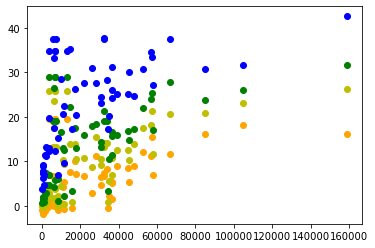

In [33]:
#matplotlib.pyplot.scatter(Trees_RH.m_agb,Trees_RH.ZG,color='r') 
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH25,color='orange') 
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH50,color='y')
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH75,color='g')
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH100,color='b')
matplotlib.pyplot.show()

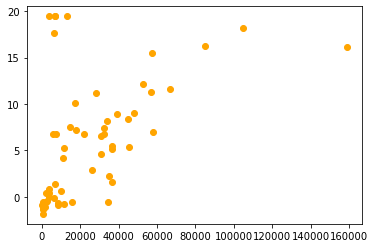

In [34]:
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH25,color='orange') 

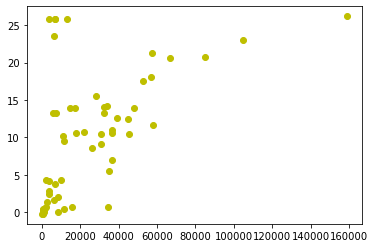

In [35]:
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH50,color='y')

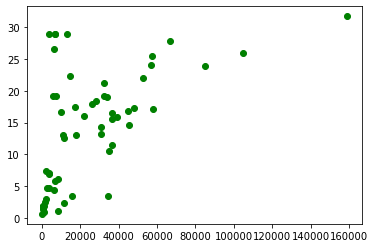

In [36]:
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH75,color='g')

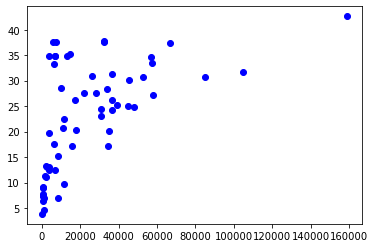

In [37]:
matplotlib.pyplot.scatter(PLOT_RH.AGB,PLOT_RH.RH100,color='b')